## Import

In [1]:
import pandas as pd
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from sklearn.metrics import r2_score
from IPython.display import clear_output
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from reload_recursive import reload_recursive
from statsmodels.stats.mediation import Mediation


from mri_data import file_manager as fm

In [2]:
# reload_recursive(helpers)

## Load Data

### Clinical and Volumes

In [3]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/choroid_associations"
)

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
)
ventricle_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/paper1/data0/ventricle_volumes.csv",
    index_col="subid",
)

tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid"
)
df = df.join([choroid_volumes, tiv, ventricle_volumes, sdmt["SDMT"]])
df["SDMT"] = pd.to_numeric(df["SDMT"], errors="coerce")
df["thalamus_sqrt"] = np.sqrt(df["thalamus"])
df["thalamus_curt"] = np.sqrt(df["thalamus"] ** 3)
df["cortical_thickness_inv"] = 1 / df["cortical_thickness"]
df["ventricle_logtrans"] = np.log(df["ventricle_volume"])

df_z = df.copy()
numeric_cols = df.select_dtypes(include="number").columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps["viridis"].resampled(20)

colors = helpers.get_colors()

### HIPS-THOMAS Volumes and Distances

In [4]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]

ignore_structs1 = [
    "THALAMUS_1",
    "Amy_34",
    "GP_33",
    "Cla_28",
    "Acc_26",
    "Hb_13",
    "MTT_14",
]
ignore_structs2 = ["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

mni_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_centroid_centroid_dists.csv",
    index_col="index",
)
mni_dists["struct"] = hips_thomas_ref

mni_dists2 = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_choroid_struct_SDT.csv",
    index_col="index",
)
mni_dists2["struct"] = hips_thomas_ref

mni_ventricle_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_ventricle_centroid_centroid_dists.csv",
    index_col="index",
)
mni_ventricle_dists["struct"] = hips_thomas_ref


def combine_nuclei(df):
    df2 = pd.DataFrame()
    df2["anterior"] = df["AV_2"]
    df2["ventral"] = df["VA_4"] + df["VLa_5"] + df["VLP_6"] + df["VPL_7"]
    df2["intralaminar"] = df["CM_11"]
    df2["medial"] = df["MD_Pf_12"]
    df2["posterior"] = df["Pul_8"] + df["LGN_9"] + df["MGN_10"]
    df2["THALAMUS_1"] = df["THALAMUS_1"]
    return df2


def combine_nuclei2(df):
    df2 = pd.DataFrame()
    df2["anterior"] = df["AV_2"]
    df2["ventral"] = df["VA_4"] + df["VLa_5"] + df["VLP_6"] + df["VPL_7"]
    df2["medial"] = df["MD_Pf_12"] + df["CM_11"]
    df2["posterior"] = df["Pul_8"] + df["LGN_9"] + df["MGN_10"]
    df2["THALAMUS_1"] = df["THALAMUS_1"]
    return df2


mni_combined_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_combined_nuclei_centroid_centroid_dists.csv",
    index_col="index",
)

df_thomas2 = combine_nuclei2(df_thomas)
grouped_nuclei = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
df_thomas2_z = df_thomas2.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm = df_thomas2.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas2_norm_z = df_thomas2_norm.apply(stats.zscore, nan_policy="omit")

df_thomas2_left = combine_nuclei2(df_thomas_left)
df_thomas2_left_z = df_thomas2_left.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_left = df_thomas2.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas2_norm_left_z = df_thomas2_norm_left.apply(stats.zscore, nan_policy="omit")

df_thomas2_right = combine_nuclei2(df_thomas_right)
df_thomas2_right_z = df_thomas2_right.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_right = df_thomas2.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas2_norm_right_z = df_thomas2_norm_right.apply(stats.zscore, nan_policy="omit")

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/p

In [5]:
hips_thomas_ref

index
1     THALAMUS_1
2           AV_2
4           VA_4
5          VLa_5
6          VLP_6
7          VPL_7
8          Pul_8
9          LGN_9
10        MGN_10
11         CM_11
12      MD_Pf_12
13         Hb_13
14        MTT_14
26        Acc_26
27        Cau_27
28        Cla_28
29        GPe_29
30        GPi_30
31        Put_31
32         RN_32
33         GP_33
34        Amy_34
Name: struct, dtype: object

## Functions

In [7]:
def regress_all_nuclei(model_data, covariates, outcome, structs):
    pvals = {}
    coefs = {}
    se = {}

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for struct in structs:
        formula = f"{outcome} ~ {struct}*dzdur*dz_type5 {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[struct] = res.pvalues[struct]
        coefs[struct] = res.params[struct]
        se[struct] = res.HC0_se[struct]
        all_results[struct] = res

    regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
    regression_results["p_fdr"] = stats.false_discovery_control(
        regression_results["pvals"], method="bh"
    )
    # regression_results = regression_results.sort_values(by="coef", ascending=True)
    regression_results.insert(0, "struct", regression_results.index)
    new_index = []
    for item in regression_results.struct:
        new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

    for i, row in regression_results.iterrows():
        if row["p_fdr"] < 0.05:
            regression_results.loc[i, "coef_sig"] = row["coef"]
        else:
            regression_results.loc[i, "coef_sig"] = 0

    regression_results.index = new_index
    return regression_results

# make covariates a keyword arg
def run_regressions(model_data, covariates, pred, outcomes):
    pvals = {}
    coefs = {}
    se = {}
    llci = {}
    ulci = {}
    ci_str = {}
    r2 = {}

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for outcome in outcomes:
        formula = f"{outcome} ~ {pred} {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[outcome] = res.pvalues[pred]
        coefs[outcome] = res.params[pred]
        se[outcome] = res.HC0_se[pred]
        all_results[outcome] = res
        ci = res.conf_int()
        llci[outcome] = ci.loc[pred, 0]
        ulci[outcome] = ci.loc[pred, 1]
        ci_str[outcome] = f"[{llci[outcome]:.6f}, {ulci[outcome]:.6f}]"
        r2[outcome] = res.rsquared_adj

    regression_results = pd.DataFrame(
        {
            "coef": coefs,
            "pvals": pvals,
            "se": se,
            "llci": llci,
            "ulci": ulci,
            "ci": ci_str,
        }
    )
    regression_results["p_fdr"] = stats.false_discovery_control(
        regression_results["pvals"], method="bh"
    )
    regression_results["R2"] = r2

    # regression_results = regression_results.sort_values(by="coef", ascending=True)

    for i, row in regression_results.iterrows():
        if row["p_fdr"] < 0.05:
            regression_results.loc[i, "coef_sig"] = row["coef"]
        else:
            regression_results.loc[i, "coef_sig"] = 0

    return regression_results


def fix_hipsthomas_regression_results(regression_results: pd.DataFrame):
    regression_results.insert(0, "outcome", regression_results.index)
    new_index = []
    for item in regression_results.index:
        new_index.append(int(re.match(r".+_(\d+)$", item)[1]))
    regression_results.index = new_index
    regression_results.rename(columns={"outcome": "struct"}, inplace=True)
    return regression_results


def scatter_hist(
    x, y, ax, ax_histx, ax_histy, nbins=10, light_color=None, dark_color=None
):
    if light_color is None:
        light_color = "#1f77b4"
    if dark_color is None:
        dark_color = "#1f77b4"

    # make axes look nice
    ax_histx.set_axis_off()
    ax_histy.set_axis_off()
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")

    # the scatter plot:
    ax.scatter(x, y, color=dark_color)
    ylim = ax.get_ylim()

    # the histograms
    xbins = np.linspace(np.min(x), np.max(x), nbins)
    ybins = np.linspace(np.min(y), np.max(y), nbins)
    ax_histx.hist(x, bins=xbins, color="gray", density=True)
    ax_histy.hist(
        y, bins=ybins, orientation="horizontal", color=light_color, density=True
    )

    # kde to plot on histograms
    densityx = stats.gaussian_kde(x.dropna())
    densityy = stats.gaussian_kde(y.dropna())
    xx = np.linspace(np.min(x), np.max(x), 50)
    xy = np.linspace(np.min(y), np.max(y), 50)
    ax_histx.plot(xx, densityx(xx), color="black")
    ax_histy.plot(densityy(xy), xy, color=dark_color)

    ax_histy.set_ylim(ylim)


def plot_regression(
    data,
    predictor,
    outcome,
    covariates,
    xlabel=None,
    ylabel=None,
    title=None,
    color="blue1",
):
    plus_covariates = ""
    if len(covariates) > 0:
        plus_covariates = f"+ {' + '.join(covariates)}"
    if xlabel is None:
        xlabel = predictor
    if ylabel is None:
        ylabel = outcome
    if title is None:
        title = f"{outcome} vs {predictor}"

    light_color = colors[f"light {color}"]
    dark_color = colors[f"dark {color}"]

    formula = f"{outcome} ~ {predictor} {plus_covariates}"
    res = sm.OLS.from_formula(formula, data=data).fit()
    x, y_pred, y_lims = helpers.get_regression_y(data, res, predictor, outcome)

    fig, axs = plt.subplot_mosaic(
        [["histx", "."], ["scatter", "histy"]],
        figsize=(8, 6),
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        layout="constrained",
    )
    axs["scatter"].plot(x, y_pred, color="black")
    axs["scatter"].fill_between(x, y_lims[0], y_lims[1], alpha=0.4, color=light_color)
    scatter_hist(
        data[predictor],
        data[outcome],
        axs["scatter"],
        axs["histx"],
        axs["histy"],
        light_color=light_color,
        dark_color=dark_color,
    )

    axs["scatter"].set_ylabel(ylabel)
    axs["scatter"].set_xlabel(xlabel)
    fig.suptitle(title)
    return fig, axs

## Assumption Checks

In [ ]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])

variables = ["choroid_volume", "cortical_thickness", "THALAMUS_1", "t2lv", "PRL"]

vif_data = model_data[variables]
vif = pd.DataFrame()
vif["var"] = vif_data.columns
vif.set_index("var", inplace=True)
vif["VIF"] = [
    variance_inflation_factor(
        vif_data.values,
        i,
    )
    for i in range(len(vif_data.columns))
]

vif

ShapiroResult(statistic=0.9952982257428726, pvalue=0.07867740797828145)

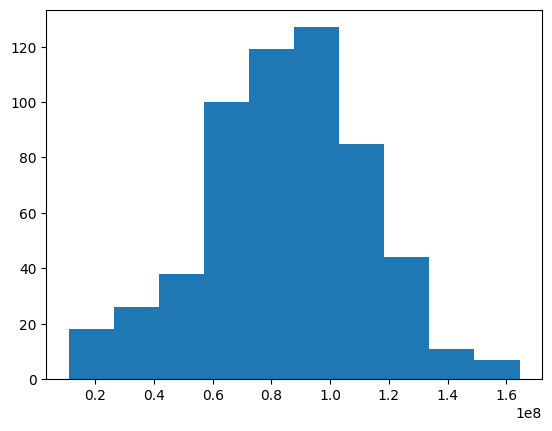

In [ ]:
check = np.power(df_thomas["THALAMUS_1"], 2)
plt.hist(check)
stats.shapiro(check, nan_policy="omit")


(array([ 23.,  50.,  83., 137., 117.,  85.,  50.,  16.,  10.,   4.]),
 array([  2.559994 ,  27.2896887,  52.0193834,  76.7490781, 101.4787728,
        126.2084675, 150.9381622, 175.6678569, 200.3975516, 225.1272463,
        249.856941 ]),
 <BarContainer object of 10 artists>)

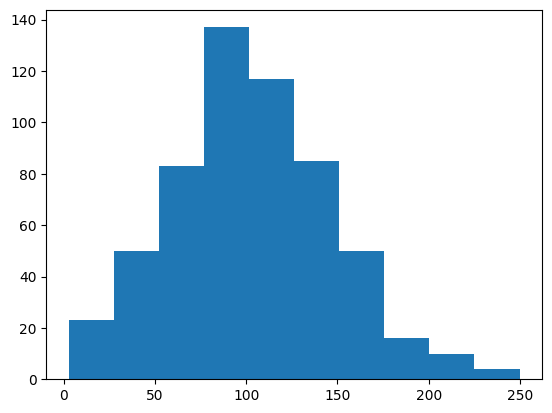

In [ ]:
plt.hist(df_thomas["AV_2"])

## Analysis

### CP and Other Inflammatory Markers

In [7]:
outcomes = [
    "t2lv_logtrans",
    "THALAMUS_1",
    "brain",
    "grey",
    "white",
    "cortical_thickness",
    "ventricle_logtrans",
]
covariates = "age + Female + tiv"

df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])

regression_results = run_regressions(model_data, covariates, "choroid_volume", outcomes)
regression_results.sort_values(by="coef", key=np.abs, ascending=False, inplace=True)
regression_results.to_excel(fig_path / "choroid_vs_inflammatory_markers.xlsx")
regression_results

,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
ventricle_logtrans,0.620113,1.869062e-53,0.032682,0.550890,0.689335,"[0.550890, 0.689335]",1.308343e-52,0.550600,0.620113
THALAMUS_1,-0.423348,3.496056e-24,0.046542,-0.500794,-0.345901,"[-0.500794, -0.345901]",1.223619e-23,0.430558,-0.423348
t2lv_logtrans,0.335684,1.053844e-12,0.050267,0.245655,0.425712,"[0.245655, 0.425712]",1.844227e-12,0.187313,0.335684
cortical_thickness,-0.325829,1.913385e-13,0.045456,-0.410309,-0.241349,"[-0.410309, -0.241349]",4.464564e-13,0.324296,-0.325829
brain,-0.297022,4.109655e-11,0.043998,-0.383336,-0.210707,"[-0.383336, -0.210707]",5.753517e-11,0.305914,-0.297022
white,-0.287184,2.694354e-09,0.044987,-0.380186,-0.194183,"[-0.380186, -0.194183]",3.143414e-09,0.188390,-0.287184
grey,-0.240896,2.062966e-08,0.045075,-0.323855,-0.157938,"[-0.323855, -0.157938]",2.062966e-08,0.358058,-0.240896


#### Plot markers vs CP

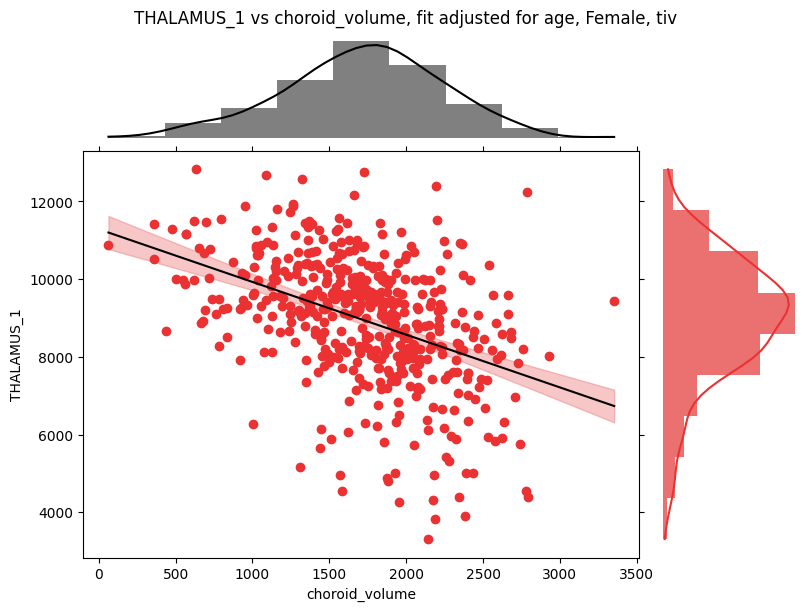

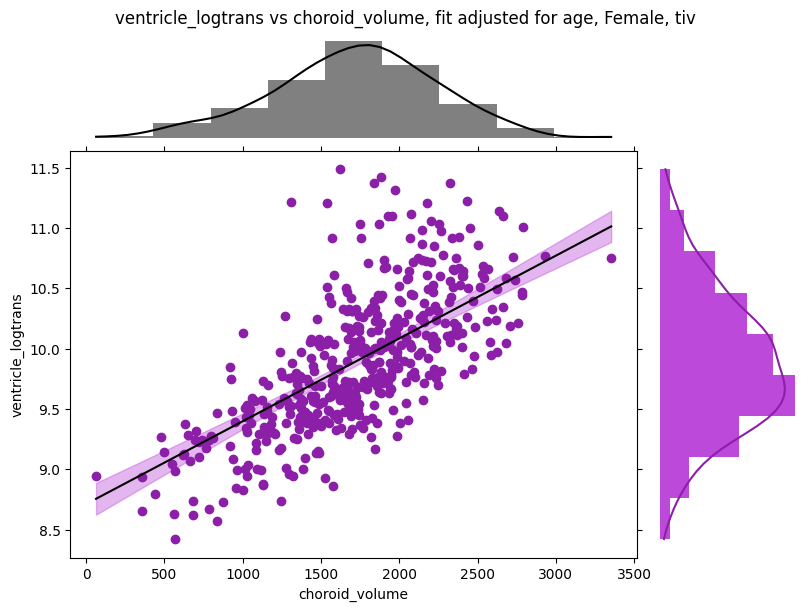

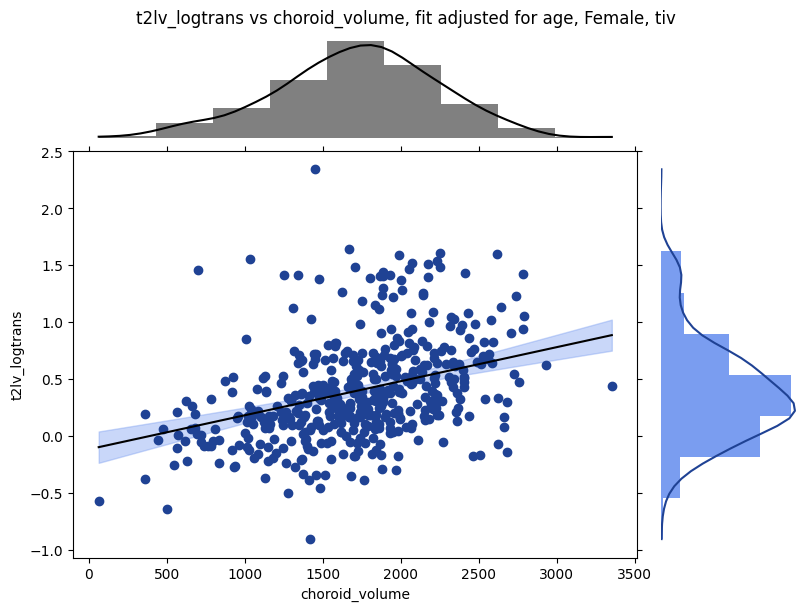

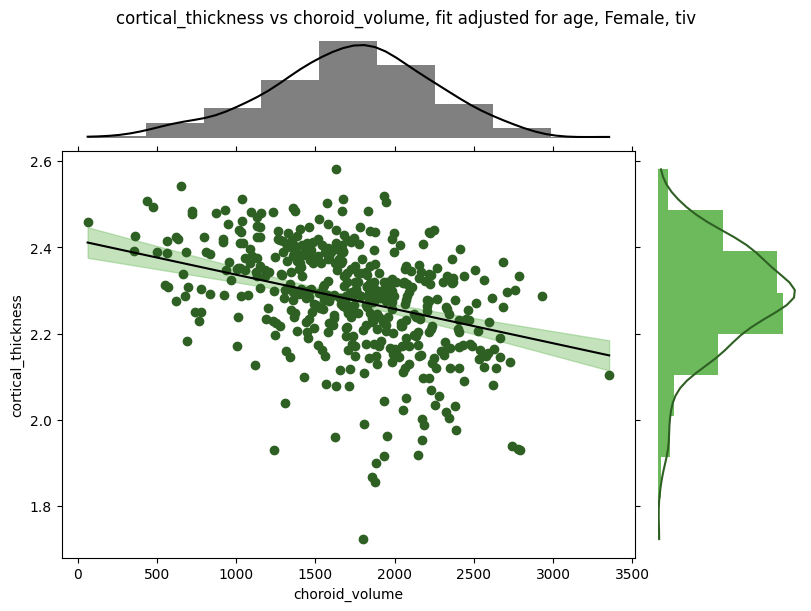

In [8]:
plot_data = df.join([df_thomas])
plot_data = plot_data[plot_data.dz_type2 == "MS"]
covariates = ["age", "Female", "tiv"]

x_name = "choroid_volume"
y_name = "THALAMUS_1"
title = f"{y_name} vs {x_name}, fit adjusted for {', '.join(covariates)}"
fig, axs = plot_regression(
    plot_data,
    x_name,
    y_name,
    covariates,
    color="red1",
    xlabel=x_name,
    ylabel=y_name,
    title=title,
)
fig.savefig(fig_path / f"plot_{y_name}_vs_{x_name}.png", dpi=300)

x_name = "choroid_volume"
y_name = "ventricle_logtrans"
title = f"{y_name} vs {x_name}, fit adjusted for {', '.join(covariates)}"
fig, axs = plot_regression(
    plot_data,
    x_name,
    y_name,
    covariates,
    color="purple1",
    xlabel=x_name,
    ylabel=y_name,
    title=title,
)
fig.savefig(fig_path / f"plot_{y_name}_vs_{x_name}.png", dpi=300)

x_name = "choroid_volume"
y_name = "t2lv_logtrans"
title = f"{y_name} vs {x_name}, fit adjusted for {', '.join(covariates)}"
fig, axs = plot_regression(
    plot_data,
    x_name,
    y_name,
    covariates,
    color="blue1",
    xlabel=x_name,
    ylabel=y_name,
    title=title,
)
fig.savefig(fig_path / f"plot_{y_name}_vs_{x_name}.png", dpi=300)

x_name = "choroid_volume"
y_name = "cortical_thickness"
title = f"{y_name} vs {x_name}, fit adjusted for {', '.join(covariates)}"
fig, axs = plot_regression(
    plot_data,
    x_name,
    y_name,
    covariates,
    color="green1",
    xlabel=x_name,
    ylabel=y_name,
    title=title,
)
fig.savefig(fig_path / f"plot_{y_name}_vs_{x_name}.png", dpi=300)

### HIPS-THOMAS and Inflammatory Markers

#### Each side for cartoon figure

In [9]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data_left = df_ms_z.join([df_thomas_left_z])
model_data_right = df_ms_z.join([df_thomas_right_z])

structs = hips_thomas_ref[thalamic_nuclei]
covariates = "age + Female + tiv + THALAMUS_1"

predictors = ["choroid_volume"]
regression_results_left = {}
regression_results_right = {}
for i, predictor in enumerate(predictors):
    results_left = run_regressions(model_data_left, covariates, predictor, structs)
    results_left = fix_hipsthomas_regression_results(results_left)
    results_right = run_regressions(model_data_right, covariates, predictor, structs)
    results_right = fix_hipsthomas_regression_results(results_right)
    all_coefs = pd.concat([results_left.coef, results_right.coef])
    bins = np.linspace(all_coefs.min() - 0.0001, all_coefs.max() - 0.0001, 10)
    ranks = np.digitize(results_left.coef, bins)
    results_left.insert(1, "bin", ranks)
    ranks = np.digitize(results_right.coef, bins)
    results_right.insert(1, "bin", ranks)
    regression_results_left[predictor] = results_left
    regression_results_right[predictor] = results_right

In [10]:
regression_results_right["choroid_volume"].sort_values(by="bin")

,struct,bin,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
11,CM_11,1,-0.084056,0.030374,0.038982,-0.160111,-0.008002,"[-0.160111, -0.008002]",0.043391,0.547269,-0.084056
12,MD_Pf_12,1,-0.082429,0.000599,0.024155,-0.129302,-0.035557,"[-0.129302, -0.035557]",0.001998,0.835186,-0.082429
8,Pul_8,2,-0.050719,0.013301,0.019908,-0.090824,-0.010614,"[-0.090824, -0.010614]",0.022168,0.873224,-0.050719
9,LGN_9,2,-0.062749,0.131316,0.046237,-0.144324,0.018825,"[-0.144324, 0.018825]",0.148746,0.462980,0.000000
10,MGN_10,2,-0.054514,0.133871,0.038469,-0.125853,0.016825,"[-0.125853, 0.016825]",0.148746,0.611104,0.000000
2,AV_2,4,0.000664,0.986864,0.043178,-0.078510,0.079838,"[-0.078510, 0.079838]",0.986864,0.464347,0.000000
5,VLa_5,7,0.104993,0.007940,0.040900,0.027608,0.182378,"[0.027608, 0.182378]",0.018264,0.506068,0.104993
6,VLP_6,7,0.102144,0.000158,0.027830,0.049458,0.154829,"[0.049458, 0.154829]",0.000789,0.781683,0.102144
7,VPL_7,7,0.087854,0.009132,0.036923,0.021912,0.153796,"[0.021912, 0.153796]",0.018264,0.653724,0.087854
4,VA_4,9,0.159357,0.000003,0.031014,0.092713,0.226001,"[0.092713, 0.226001]",0.000035,0.654480,0.159357


In [11]:
regression_results_left["choroid_volume"].sort_values(by="bin")

,struct,bin,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
9,LGN_9,1,-0.109975,0.008952,0.048077,-0.192303,-0.027647,"[-0.192303, -0.027647]",0.015451,0.475554,-0.109975
10,MGN_10,1,-0.103167,0.003281,0.035316,-0.171763,-0.034571,"[-0.171763, -0.034571]",0.008204,0.626266,-0.103167
11,CM_11,1,-0.099472,0.010816,0.041504,-0.175859,-0.023084,"[-0.175859, -0.023084]",0.015451,0.531398,-0.099472
12,MD_Pf_12,2,-0.057094,0.019227,0.027457,-0.104851,-0.009338,"[-0.104851, -0.009338]",0.024034,0.829570,-0.057094
8,Pul_8,3,-0.039427,0.061309,0.019897,-0.080731,0.001877,"[-0.080731, 0.001877]",0.068121,0.867744,0.000000
2,AV_2,5,0.046594,0.235955,0.043235,-0.030563,0.123751,"[-0.030563, 0.123751]",0.235955,0.518875,0.000000
7,VPL_7,6,0.081436,0.009579,0.031761,0.019922,0.142950,"[0.019922, 0.142950]",0.015451,0.712531,0.081436
6,VLP_6,8,0.119346,0.000008,0.024299,0.067309,0.171382,"[0.067309, 0.171382]",0.000042,0.793657,0.119346
5,VLa_5,9,0.161444,0.000045,0.039582,0.084441,0.238446,"[0.084441, 0.238446]",0.000150,0.530638,0.161444
4,VA_4,10,0.182261,0.000002,0.033649,0.108356,0.256167,"[0.108356, 0.256167]",0.000017,0.592424,0.182261


#### Bilateral for table

In [11]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])

structs = hips_thomas_ref[thalamic_nuclei]
covariates = "THALAMUS_1 + age + Female + tiv"

predictors = ["choroid_volume", "ventricle_volume", "cortical_thickness", "t2lv", "PRL", "brain", "white", "grey"]
regression_results = {}
for i, predictor in enumerate(predictors):
    result = run_regressions(model_data, covariates, predictor, structs)
    regression_results[predictor] = fix_hipsthomas_regression_results(result)

save_path = fig_path / "hipsthomas_and_inflammatory_markers.xlsx"

with pd.ExcelWriter(save_path) as writer:
    for predictor in regression_results:
        regression_results[predictor].to_excel(writer, sheet_name=predictor)
regression_results['choroid_volume']

,struct,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
2,AV_2,0.035563,3.376318e-01,0.041196,-0.037245,0.108370,"[-0.037245, 0.108370]",0.337632,0.561576,0.000000
4,VA_4,0.179250,1.321608e-07,0.029377,0.113523,0.244976,"[0.113523, 0.244976]",0.000001,0.674796,0.179250
5,VLa_5,0.140753,1.350786e-04,0.037000,0.068899,0.212607,"[0.068899, 0.212607]",0.000450,0.587137,0.140753
6,VLP_6,0.112282,7.848105e-06,0.024144,0.063472,0.161091,"[0.063472, 0.161091]",0.000039,0.817064,0.112282
7,VPL_7,0.088219,2.359570e-03,0.027668,0.031524,0.144915,"[0.031524, 0.144915]",0.004719,0.751606,0.088219
8,Pul_8,-0.040044,3.383510e-02,0.018009,-0.077016,-0.003072,"[-0.077016, -0.003072]",0.042294,0.894306,-0.040044
9,LGN_9,-0.073108,5.723033e-02,0.041479,-0.148471,0.002255,"[-0.148471, 0.002255]",0.063589,0.558797,0.000000
10,MGN_10,-0.073235,2.034436e-02,0.030393,-0.135054,-0.011415,"[-0.135054, -0.011415]",0.029063,0.705842,-0.073235
11,CM_11,-0.102487,3.888490e-03,0.037553,-0.171894,-0.033081,"[-0.171894, -0.033081]",0.006481,0.622440,-0.102487
12,MD_Pf_12,-0.069110,1.179600e-03,0.021319,-0.110717,-0.027503,"[-0.110717, -0.027503]",0.002949,0.871944,-0.069110


#### Partial Correlation

Regress choroid_volume against whole thalamus and covariates, then do a regression of each subnucleus against the residuals of the choroid_volume

In [22]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])

structs = hips_thomas_ref[thalamic_nuclei]
covariates = "age + Female + tiv + THALAMUS_1"
res = sm.OLS.from_formula(f"choroid_volume ~ {covariates}", model_data).fit()
model_data['choroid_resid'] = res.resid

struct_resid_names = []
for struct in structs:
    res = sm.OLS.from_formula(f"{struct} ~ {covariates}", model_data).fit()
    model_data[f"{struct}_resid"] = res.resid
    struct_resid_names.append(f"{struct}_resid")

result = run_regressions(model_data, "", "choroid_resid", struct_resid_names)
result

,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
AV_2_resid,0.035563,3.355468e-01,0.041196,-0.036930,0.108056,"[-0.036930, 0.108056]",0.335547,-0.000151,0.000000
VA_4_resid,0.179250,1.166694e-07,0.029377,0.113807,0.244692,"[0.113807, 0.244692]",0.000001,0.056509,0.179250
VLa_5_resid,0.140753,1.263245e-04,0.037000,0.069210,0.212296,"[0.069210, 0.212296]",0.000421,0.028998,0.140753
VLP_6_resid,0.112282,7.168844e-06,0.024144,0.063683,0.160880,"[0.063683, 0.160880]",0.000036,0.040303,0.112282
VPL_7_resid,0.088219,2.258564e-03,0.027668,0.031769,0.144670,"[0.031769, 0.144670]",0.004517,0.017733,0.088219
Pul_8_resid,-0.040044,3.307203e-02,0.018009,-0.076856,-0.003231,"[-0.076856, -0.003231]",0.041340,0.007585,-0.040044
LGN_9_resid,-0.073108,5.616278e-02,0.041479,-0.148145,0.001929,"[-0.148145, 0.001929]",0.062403,0.005675,0.000000
MGN_10_resid,-0.073235,1.980786e-02,0.030393,-0.134787,-0.011682,"[-0.134787, -0.011682]",0.028297,0.009473,-0.073235
CM_11_resid,-0.102487,3.736944e-03,0.037553,-0.171594,-0.033381,"[-0.171594, -0.033381]",0.006228,0.015791,-0.102487
MD_Pf_12_resid,-0.069110,1.122816e-03,0.021319,-0.110537,-0.027683,"[-0.110537, -0.027683]",0.002807,0.020444,-0.069110


In [16]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])
model_data = pd.concat([model_data, pd.get_dummies(model_data["dz_type5"])], axis=1)

structs = hips_thomas_ref[thalamic_nuclei]


formula = "choroid_volume ~ ventricle_volume + age + Female + tiv + THALAMUS_1"
res = sm.OLS.from_formula(formula, data=model_data).fit()
model_data["choroid_resid"] = res.resid

predictor1 = "choroid_volume"
predictor2 = "ventricle_volume"
predictor3 = "choroid_resid"
covariates1 = "age + Female + tiv + ventricle_volume + THALAMUS_1"
covariates2 = "age + Female + tiv + choroid_volume"
covariates3 = "age + Female + tiv"
result = run_regressions(model_data, covariates1, predictor1, structs)
# result.to_excel(fig_path / "hipsthomas_ventricle_choroid_control.xlsx")
result

,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
AV_2,0.021069,0.584037,0.041681,-0.054501,0.096639,"[-0.054501, 0.096639]",0.584037,0.561865,0.000000
VA_4,0.147390,0.000016,0.029790,0.080928,0.213852,"[0.080928, 0.213852]",0.000162,0.689834,0.147390
VLa_5,0.121646,0.001380,0.039670,0.047369,0.195923,"[0.047369, 0.195923]",0.004601,0.590731,0.121646
VLP_6,0.087606,0.000623,0.025361,0.037634,0.137578,"[0.037634, 0.137578]",0.003116,0.822359,0.087606
VPL_7,0.052966,0.072027,0.028219,-0.004760,0.110691,"[-0.004760, 0.110691]",0.090034,0.761446,0.000000
Pul_8,-0.040618,0.036418,0.019458,-0.078658,-0.002579,"[-0.078658, -0.002579]",0.072837,0.895837,0.000000
LGN_9,-0.044989,0.256280,0.040753,-0.122769,0.032792,"[-0.122769, 0.032792]",0.284755,0.564666,0.000000
MGN_10,-0.060316,0.065266,0.030435,-0.124461,0.003828,"[-0.124461, 0.003828]",0.090034,0.706628,0.000000
CM_11,-0.083417,0.022884,0.039041,-0.155219,-0.011615,"[-0.155219, -0.011615]",0.057209,0.625229,0.000000
MD_Pf_12,-0.040051,0.062183,0.021684,-0.082149,0.002048,"[-0.082149, 0.002048]",0.090034,0.878465,0.000000


In [ ]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])
model_data = pd.concat([model_data, pd.get_dummies(model_data["dz_type5"])], axis=1)

structs = hips_thomas_ref
pvals = {}
coefs = {}
interaction_coefs = {}
interaction_p = {}
se = {}
for struct in structs:
    formula = f"{struct} ~ choroid_volume*dzdur + age + Female + tiv"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues["dzdur"]
    coefs[struct] = res.params["dzdur"]
    interaction_coefs[struct] = res.params["choroid_volume:dzdur"]
    interaction_p[struct] = res.pvalues["choroid_volume:dzdur"]

regression_results = pd.DataFrame(
    {
        "coef": coefs,
        "pvals": pvals,
        "interaction_coefs": interaction_coefs,
        "interaction_p": interaction_p,
    }
)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.index:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))
regression_results.index = new_index

regression_results = regression_results.sort_values(by="coef")
regression_results

,struct,coef,pvals,interaction_coefs,interaction_p
12,MD_Pf_12,-0.255628,1.068645e-07,0.020159,0.615066
1,THALAMUS_1,-0.253020,2.528566e-08,0.007496,0.842759
8,Pul_8,-0.246496,3.117359e-07,0.017728,0.659224
7,VPL_7,-0.191133,1.315883e-04,-0.046530,0.267921
9,LGN_9,-0.181375,5.739029e-04,-0.031983,0.470324
26,Acc_26,-0.174475,1.371580e-04,0.005611,0.883885
6,VLP_6,-0.169492,4.072560e-04,-0.033985,0.399242
30,GPi_30,-0.164983,1.081058e-03,0.118227,0.005570
10,MGN_10,-0.158180,7.163014e-04,0.041144,0.295711
31,Put_31,-0.157012,4.071974e-04,0.020878,0.576063


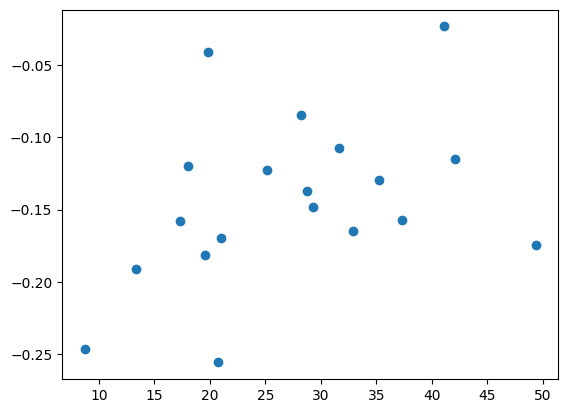

In [ ]:
regression_results["dist"] = mni_dists["left_exposure"]
plt.scatter(regression_results["dist"], regression_results["coef"])

In [41]:
structs = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]

df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas2_z])

predictor1 = "choroid_volume"
predictor2 = "ventricle_volume"
covariates1 = "age + Female + tiv + THALAMUS_1 + ventricle_volume"
covariates2 = "age + Female + tiv + THALAMUS_1 + choroid_volume"
result = run_regressions(model_data, covariates1, predictor1, structs)
result[["coef", "pvals", "p_fdr", "coef_sig"]]
# result.to_excel(fig_path / "hipsthomas_grouped_ventricle_choroid_control.xlsx")

,coef,pvals,p_fdr,coef_sig
anterior,0.021069,0.584037,0.584037,0.000000
ventral,0.098347,0.000003,0.000012,0.098347
medial,-0.048079,0.014542,0.029006,-0.048079
posterior,-0.042849,0.021754,0.029006,-0.042849


In [ ]:
formula = "posterior ~ choroid_volume + ventricle_volume + age + Female + tiv"
res = sm.OLS.from_formula(formula, data = model_data).fit()
res.wald_test("choroid_volume = ventricle_volume")

                            OLS Regression Results                            
Dep. Variable:              posterior   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     629.3
Date:                Fri, 27 Jun 2025   Prob (F-statistic):          9.85e-231
Time:                        17:16:11   Log-Likelihood:                -111.99
No. Observations:                 467   AIC:                             240.0
Df Residuals:                     459   BIC:                             273.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [33]:
formula = f"medial ~ choroid_volume*t2lv + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 medial   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     72.95
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           9.64e-64
Time:                        23:39:19   Log-Likelihood:                -516.55
No. Observations:                 468   AIC:                             1047.
Df Residuals:                     461   BIC:                             1076.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0143    

#### Deep Gray

In [7]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])

structs = hips_thomas_ref[deep_grey]
covariates = "age + Female  + tiv"

predictors = ["choroid_volume", "ventricle_volume", "cortical_thickness", "t2lv", "PRL"]
regression_results = {}
for i, predictor in enumerate(predictors):
    result = run_regressions(model_data, covariates, predictor, structs)
    regression_results[predictor] = fix_hipsthomas_regression_results(result)

save_path = fig_path / "deep_grey_and_inflammatory_markers.xlsx"

with pd.ExcelWriter(save_path) as writer:
    for predictor in regression_results:
        regression_results[predictor].to_excel(writer, sheet_name=predictor)

In [8]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])
model_data = pd.concat([model_data, pd.get_dummies(model_data["dz_type5"])], axis=1)

structs = hips_thomas_ref[deep_grey]

predictor1 = "choroid_volume"
predictor2 = "ventricle_volume"
covariates1 = "age + Female + tiv + ventricle_volume"
covariates2 = "age + Female + tiv + choroid_volume"
result_choroid = run_regressions(model_data, covariates1, predictor1, structs)
result_ventricle = run_regressions(model_data, covariates2, predictor2, structs)

save_path = fig_path / "deep_grey_choroid_ventricle_model.xlsx"

with pd.ExcelWriter(save_path) as writer:
    result_choroid.to_excel(writer, sheet_name="choroid_volume")
    result_ventricle.to_excel(writer, sheet_name="ventricle_volume")

result_choroid

,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
Hb_13,-0.139660,0.009694,0.052388,-0.245324,-0.033996,"[-0.245324, -0.033996]",0.029082,0.146131,-0.139660
MTT_14,0.009976,0.833166,0.044323,-0.083037,0.102988,"[-0.083037, 0.102988]",0.833166,0.267961,0.000000
Acc_26,-0.085925,0.034027,0.040419,-0.165345,-0.006505,"[-0.165345, -0.006505]",0.051041,0.537562,0.000000
Cau_27,-0.104329,0.026438,0.048507,-0.196395,-0.012263,"[-0.196395, -0.012263]",0.047589,0.380276,-0.104329
Cla_28,-0.115504,0.004682,0.041041,-0.195370,-0.035637,"[-0.195370, -0.035637]",0.021070,0.524163,-0.115504
GPe_29,-0.047593,0.306697,0.048599,-0.138988,0.043802,"[-0.138988, 0.043802]",0.394325,0.350448,0.000000
GPi_30,-0.045101,0.355478,0.044463,-0.140921,0.050720,"[-0.140921, 0.050720]",0.399913,0.282617,0.000000
Put_31,-0.090843,0.025448,0.039535,-0.170475,-0.011212,"[-0.170475, -0.011212]",0.047589,0.492876,-0.090843
RN_32,-0.131088,0.001506,0.043124,-0.211776,-0.050400,"[-0.211776, -0.050400]",0.013558,0.485070,-0.131088


## Choroid and Disease Duration

Spline analysis

In [9]:
from patsy import cr  # make cr() visible in the eval namespace
from sklearn.preprocessing import StandardScaler

n_splines = 3
# time_pts = [2, 15, 32]
# time_pt_colors = ["steelblue", "burlywood", "firebrick"]
time_pts = [2, 16]
time_pt_colors = ["steelblue", "firebrick"]

scaler_dzdur = StandardScaler()
scaler_cp = StandardScaler()

raw_data = df[df_z.dz_type2 == "MS"].join([df_thomas2])
model_data = df_z[df_z.dz_type2 == "MS"]
model_data = model_data.join([df_thomas2_z])
model_data['THALAMUS_1'] = df_thomas_z['THALAMUS_1']
model_data["dzdur"] = scaler_dzdur.fit_transform(
    raw_data.loc[model_data.index, ["dzdur"]]
)
model_data["choroid_volume"] = scaler_cp.fit_transform(
    raw_data.loc[model_data.index, ["choroid_volume"]]
)

scaler_thals = {}
models = {}

structs = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
for thalamus_label in structs:
    scaler_thals[thalamus_label] = StandardScaler()

    model_data[thalamus_label] = scaler_thals[thalamus_label].fit_transform(
        raw_data.loc[model_data.index, [thalamus_label]] / 1000
    )

    models[thalamus_label] = sm.OLS.from_formula(
        f"{thalamus_label} ~ choroid_volume * bs(dzdur, df=2, degree=2) + age + Female + tiv",
        data=model_data,
    ).fit()


dzdur_levels = scaler_dzdur.transform([[time_pt] for time_pt in time_pts]).flatten()
d = {
    "choroid_volume": np.linspace(
        model_data["choroid_volume"].min(), model_data["choroid_volume"].max()
    ),
    "dzdur": dzdur_levels,
    "age": [model_data["age"].mean()],
    "Female": [model_data["Female"].mean()],
    "tiv": [model_data["tiv"].mean()],
    "THALAMUS_1": [model_data["THALAMUS_1"].mean()]
}

test_data = (
    pd.MultiIndex.from_product(d.values(), names=d.keys())
    .to_frame()
    .reset_index(drop=True)
)

for struct in structs:
    model = models[struct]
    pred = model.get_prediction(test_data).summary_frame(alpha=0.05)

    # test_data["fit"] = scaler_thal.inverse_transform([pred["mean"]]).flatten()
    # test_data["lower"] = scaler_thal.inverse_transform([pred["mean_ci_lower"]]).flatten()
    # test_data["upper"] = scaler_thal.inverse_transform([pred["mean_ci_upper"]]).flatten()
    test_data[f"{struct}_fit"] = pred["mean"]
    test_data[f"{struct}_lower"] = pred["mean_ci_lower"]
    test_data[f"{struct}_upper"] = pred["mean_ci_upper"]

test_data["cp_raw"] = scaler_cp.inverse_transform(
    [test_data["choroid_volume"]]
).flatten()
test_data["dzdur_raw"] = scaler_dzdur.inverse_transform([test_data["dzdur"]]).flatten()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names


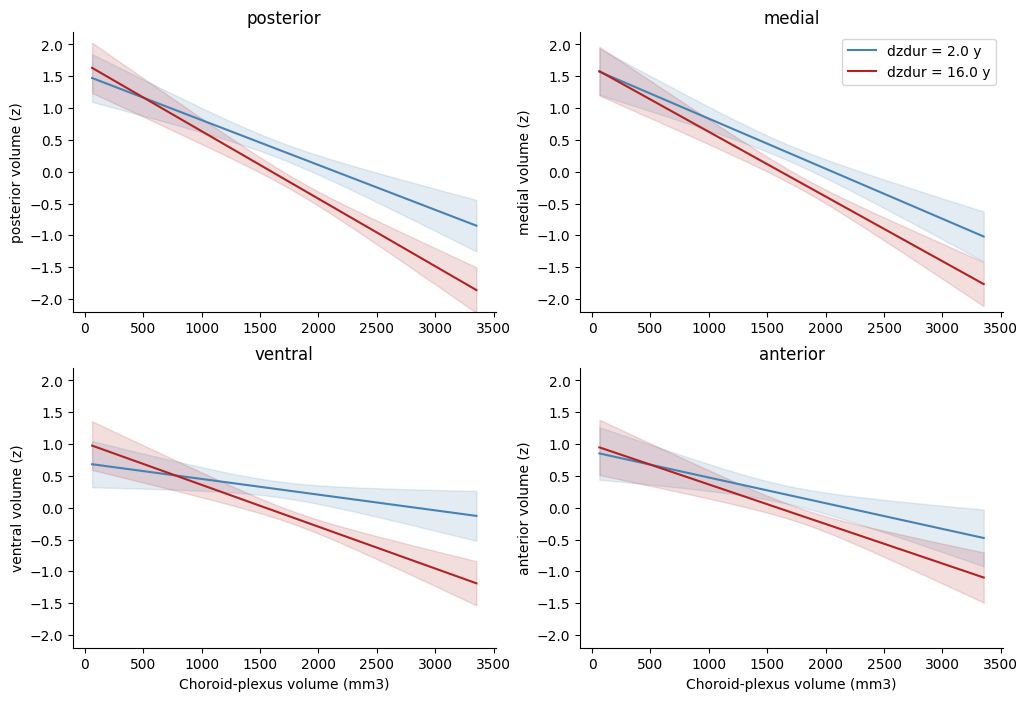

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplot_mosaic(
    [["posterior", "medial"], ["ventral", "anterior"]], figsize=(12, 8)
)

for struct in structs:
    ax = axes[struct]
    for dz, colour in zip(dzdur_levels, time_pt_colors):
        sub = test_data[np.abs(test_data["dzdur"] - dz)<0.001]
        dzdur_label = scaler_dzdur.inverse_transform([[dz]]).flatten()[0]
        ax.plot(
            sub["cp_raw"],
            sub[f"{struct}_fit"],
            label=f"dzdur = {dzdur_label} y",
            color=colour,
        )
        ax.fill_between(
            sub["cp_raw"],
            sub[f"{struct}_lower"],
            sub[f"{struct}_upper"],
            color=colour,
            alpha=0.15,
        )
    sns.despine()
    ax.set_title(struct)
    ax.set_ylabel(f"{struct} volume (z)")
    ax.set_ybound([-2.2, 2.2])

axes['anterior'].set_xlabel("Choroid-plexus volume (mm3)")
axes['ventral'].set_xlabel("Choroid-plexus volume (mm3)")
axes['medial'].legend()

# plt.savefig(fig_path / "grouped_nuclei_cp_and_dzdur.png", dpi=300)

In [12]:
from marginaleffects import slopes, datagrid

model = models['posterior']
slopes(model, variables="choroid_volume", newdata=datagrid(dzdur=dzdur_levels))
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              posterior   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     41.41
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           1.08e-49
Time:                        22:02:06   Log-Likelihood:                -536.92
No. Observations:                 468   AIC:                             1092.
Df Residuals:                     459   BIC:                             1129.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [ ]:
nucleus = "posterior"
model = models[nucleus]
# 1) Omnibus CP×spline test (per nucleus)
# names will look like 'choroid_volume:cr(dzdur, df=3)[0]' etc.
L = np.zeros((3, len(model.params)))              # 3 interaction rows
for i, tag in enumerate(["[0]","[2]"]):
    col = model.params.index.get_loc(f"choroid_volume:cr(dzdur, df=3){tag}")
    L[i, col] = 1.0
wald = model.wald_test(L)
# wald.statistic, wald.df_denom, wald.pvalue
print(wald.pvalue)

# 3) Multiple testing control across nuclei
from statsmodels.stats.multitest import multipletests
pvals = np.array([wald_i.pvalue for wald_i in wald_list])  # one per nucleus
rej, qvals, *_ = multipletests(pvals, method="fdr_bh")

Check that three splines is a better model than simple interaction term

In [8]:
from statsmodels.stats.anova import anova_lm

m_rcs = sm.OLS.from_formula(
        "THALAMUS_1 ~ choroid_volume * cr(dzdur, df=3) + age + Female + tiv",
        data=model_data,
    ).fit()
m_lin = sm.OLS.from_formula(
        "THALAMUS_1 ~ choroid_volume * dzdur + age + Female + tiv", data=model_data
    ).fit()

lr_stat, lr_p, df_diff = m_rcs.compare_lr_test(m_lin)
print(anova_lm(m_lin, m_rcs, typ=1))        
print("ΔAIC =", m_lin.aic - m_rcs.aic)
print("ΔBIC =", m_lin.bic - m_rcs.bic)

   df_resid         ssr  df_diff  ss_diff         F    Pr(>F)
0     461.0  249.593551      0.0      NaN       NaN       NaN
1     459.0  242.905451      2.0   6.6881  6.318997  0.001962
ΔAIC = 8.711591512347695
ΔBIC = 0.4146549205122483


Suggestion from gpt was that if the linear model has a U type of shape, that's support for using a spline model. There's very vaguely a U shape

GPT said if spline lead to > 1-2% improvement, that's support for the spline model

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import numpy as np

def cv_rmse(model_formula):
    rmses = []
    for tr, te in KFold(n_splits=5, shuffle=True, random_state=1).split(model_data):
        m = smf.ols(model_formula, data=model_data.iloc[tr]).fit()
        y_hat = m.predict(model_data.iloc[te])
        rmses.append(np.sqrt(mean_squared_error(model_data.iloc[te]['THALAMUS_1'], y_hat)))
    return np.mean(rmses)

# rmse_lin  = cv_rmse("THALAMUS_1 ~ choroid_volume * dzdur + age + Female + tiv")
rmse_1  = cv_rmse("THALAMUS_1 ~ choroid_volume + dzdur + age + Female + tiv")
rmse_rcs  = cv_rmse("THALAMUS_1 ~ choroid_volume * cr(dzdur, df=3) + age + Female + tiv")
# rmse_2  = cv_rmse("THALAMUS_1 ~ choroid_volume + age + Female + tiv")
print("CV-RMSE simple =", rmse_1, "  spline =", rmse_rcs)
(rmse_1 - rmse_rcs)  / rmse_1

CV-RMSE simple = 0.7414884585515777   spline = 0.7369158706193059


np.float64(0.0061667688546413425)

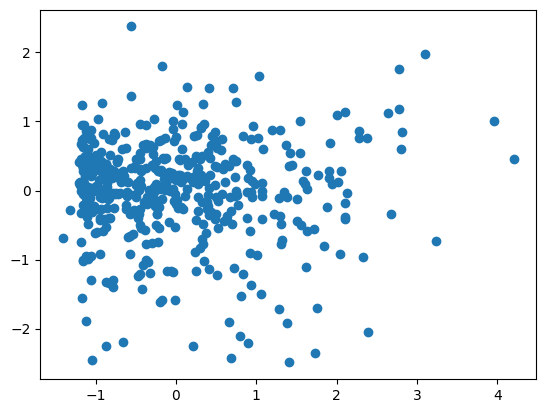

In [13]:
plt.scatter(model_data['dzdur'], m_lin.resid)

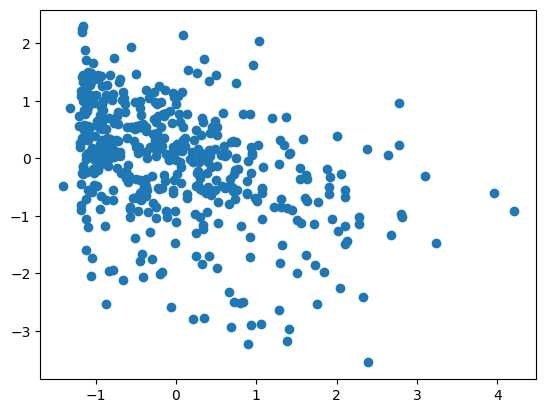

In [14]:
plt.scatter(model_data['dzdur'], model_data['THALAMUS_1'])

Intuition for spline basis functions

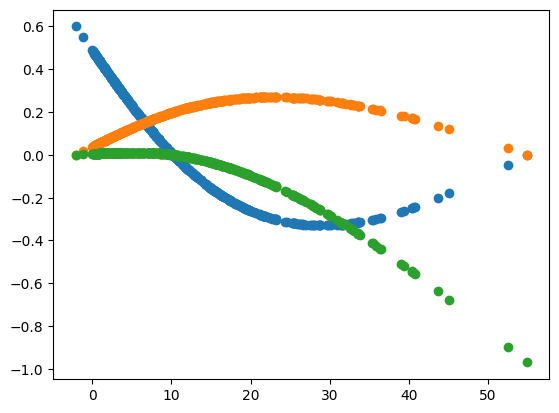

In [85]:
from patsy import dmatrix

y = dmatrix("cr(dzdur, df=3)", raw_data)
plt.scatter(raw_data['dzdur'], y[:, 1] * 0.6)
plt.scatter(raw_data['dzdur'], y[:, 2] * 0.2)
plt.scatter(raw_data['dzdur'], y[:, 3] * -0.97)

In [117]:
seg1, seg2, seg3 = np.array_split(raw_data['dzdur'].sort_values(), 3)

seg3

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


subid
1226    15.320594
2171    15.328807
2112    15.413678
1046    15.441056
1155    15.514976
          ...    
1475    40.751793
1469    43.686689
1471    45.118546
1176    52.458523
1370    54.886930
Name: dzdur, Length: 156, dtype: float64

## Scratch

In [ ]:
formula = (
    "THALAMUS_1 ~ choroid_volume + t2lv + PRL + cortical_thickness + age + Female + tiv"
)
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:             THALAMUS_1   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     126.2
Date:                Tue, 24 Jun 2025   Prob (F-statistic):          8.07e-103
Time:                        19:01:19   Log-Likelihood:                -416.95
No. Observations:                 468   AIC:                             849.9
Df Residuals:                     460   BIC:                             883.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0273      0

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[2.08961111]]), p=0.14898473329703613, df_denom=460, df_num=1>

In [ ]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])


outcome_model = sm.OLS.from_formula(
    "THALAMUS_1 ~ choroid_volume + PRL + age + tiv + Female", data=model_data
)
mediator_model = sm.GLM.from_formula(
    "PRL ~ choroid_volume + age + tiv + Female",
    data=model_data,
    family=sm.families.Poisson(),
)

mediator_model = sm.OLS.from_formula(
    "choroid_volume ~ PRL + age + tiv + Female", data=model_data
)

med = Mediation(outcome_model, mediator_model, "PRL", "choroid_volume").fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-0.066477,-0.121985,-0.018344,0.008
ACME (treated),-0.066477,-0.121985,-0.018344,0.008
ADE (control),-0.214685,-0.278625,-0.148698,0.000
ADE (treated),-0.214685,-0.278625,-0.148698,0.000
Total effect,-0.281163,-0.362700,-0.200874,0.000
Prop. mediated (control),0.234503,0.078337,0.395356,0.008
Prop. mediated (treated),0.234503,0.078337,0.395356,0.008
ACME (average),-0.066477,-0.121985,-0.018344,0.008
ADE (average),-0.214685,-0.278625,-0.148698,0.000
Prop. mediated (average),0.234503,0.078337,0.395356,0.008
